### 1. Setup and Imports

In [1]:

import sys
from pathlib import Path
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Add project root to path to ensure imports from 'src' work
if str(Path.cwd().parent) not in sys.path:
    sys.path.append(str(Path.cwd().parent))
    
from src.config import RAW_DATA_DIR, PROCESSED_DATA_DIR 
from src.utils import load_json

# Configure plot styles
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

### 2. Load Processed data 

In [5]:
# UPDATE THIS BLOCK to support both JSON and CSV
news_files = list(RAW_DATA_DIR.glob('news_*.json')) + list(RAW_DATA_DIR.glob('news_*.csv'))

if news_files:
    latest_file = max(news_files, key=lambda x: x.stat().st_mtime)
    print(f"Loading: {latest_file}")
    
    # Check extension to decide how to load
    if latest_file.suffix == '.json':
        with open(latest_file, 'r', encoding='utf-8') as f:
            news_data = json.load(f)
        df = pd.DataFrame(news_data)
    else: # CSV
        df = pd.read_csv(latest_file)
        
    # Standardize date columns
    if 'scraped_at' in df.columns:
        df['scraped_at'] = pd.to_datetime(df['scraped_at'])
    if 'published_date' in df.columns:
        df['published_date'] = pd.to_datetime(df['published_date'])
    
    print(f"\n Loaded {len(df)} articles")
# ... (rest of the code remains the same)

Loading: c:\Users\WW\Documents\modelX final round try 2\data\raw\news_20251203_185454.csv

 Loaded 40 articles


### 3. Visualization: key trends

In [13]:

# Calculate hourly metrics from the loaded data
if 'df' in locals() and len(df) > 0:
    # Determine which date column to use
    date_col = 'published_date' if 'published_date' in df.columns else 'scraped_at'
    
    # Convert to datetime if not already
    df[date_col] = pd.to_datetime(df[date_col])
    
    # Create hourly aggregations
    df_hourly = df.set_index(date_col)
    
    # Build aggregation dict based on available columns
    agg_dict = {}
    if 'sentiment_score' in df.columns:
        agg_dict['sentiment_score'] = ['mean', 'std', 'count']
    else:
        agg_dict['content'] = 'count'  # Count articles
    
    # Resample to hourly
    df_metrics = df_hourly.resample('1H').agg(agg_dict).reset_index()
    
    # Flatten column names if sentiment_score exists
    if 'sentiment_score' in df.columns:
        df_metrics.columns = ['date', 'sentiment_mean', 'sentiment_volatility', 'article_count']
    else:
        df_metrics.columns = ['date', 'article_count']
        df_metrics['sentiment_mean'] = 0
        df_metrics['sentiment_volatility'] = 0
    
    # Remove hours with no data
    df_metrics = df_metrics[df_metrics['article_count'] > 0]
    
    # Add anomaly count (if available)
    if 'is_anomaly' in df.columns:
        anomaly_hourly = df_hourly['is_anomaly'].resample('1H').sum().reset_index()
        anomaly_hourly.columns = ['date', 'anomaly_count']
        df_metrics = df_metrics.merge(anomaly_hourly, on='date', how='left')
    else:
        df_metrics['anomaly_count'] = 0  # Default value
    
    # Fill NaN volatility with 0
    df_metrics['sentiment_volatility'] = df_metrics['sentiment_volatility'].fillna(0)
    
    print(f"Created metrics dataframe with {len(df_metrics)} hours of data")
    print(df_metrics.head(10))
    print(f"\nDate range: {df_metrics['date'].min()} to {df_metrics['date'].max()}")


Created metrics dataframe with 1 hours of data
                 date  article_count  sentiment_mean  sentiment_volatility  \
0 2025-12-03 18:00:00             39               0                     0   

   anomaly_count  
0              0  

Date range: 2025-12-03 18:00:00 to 2025-12-03 18:00:00


C:\Users\WW\AppData\Local\Temp\ipykernel_4400\3763789750.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_metrics = df_hourly.resample('1H').agg(agg_dict).reset_index()


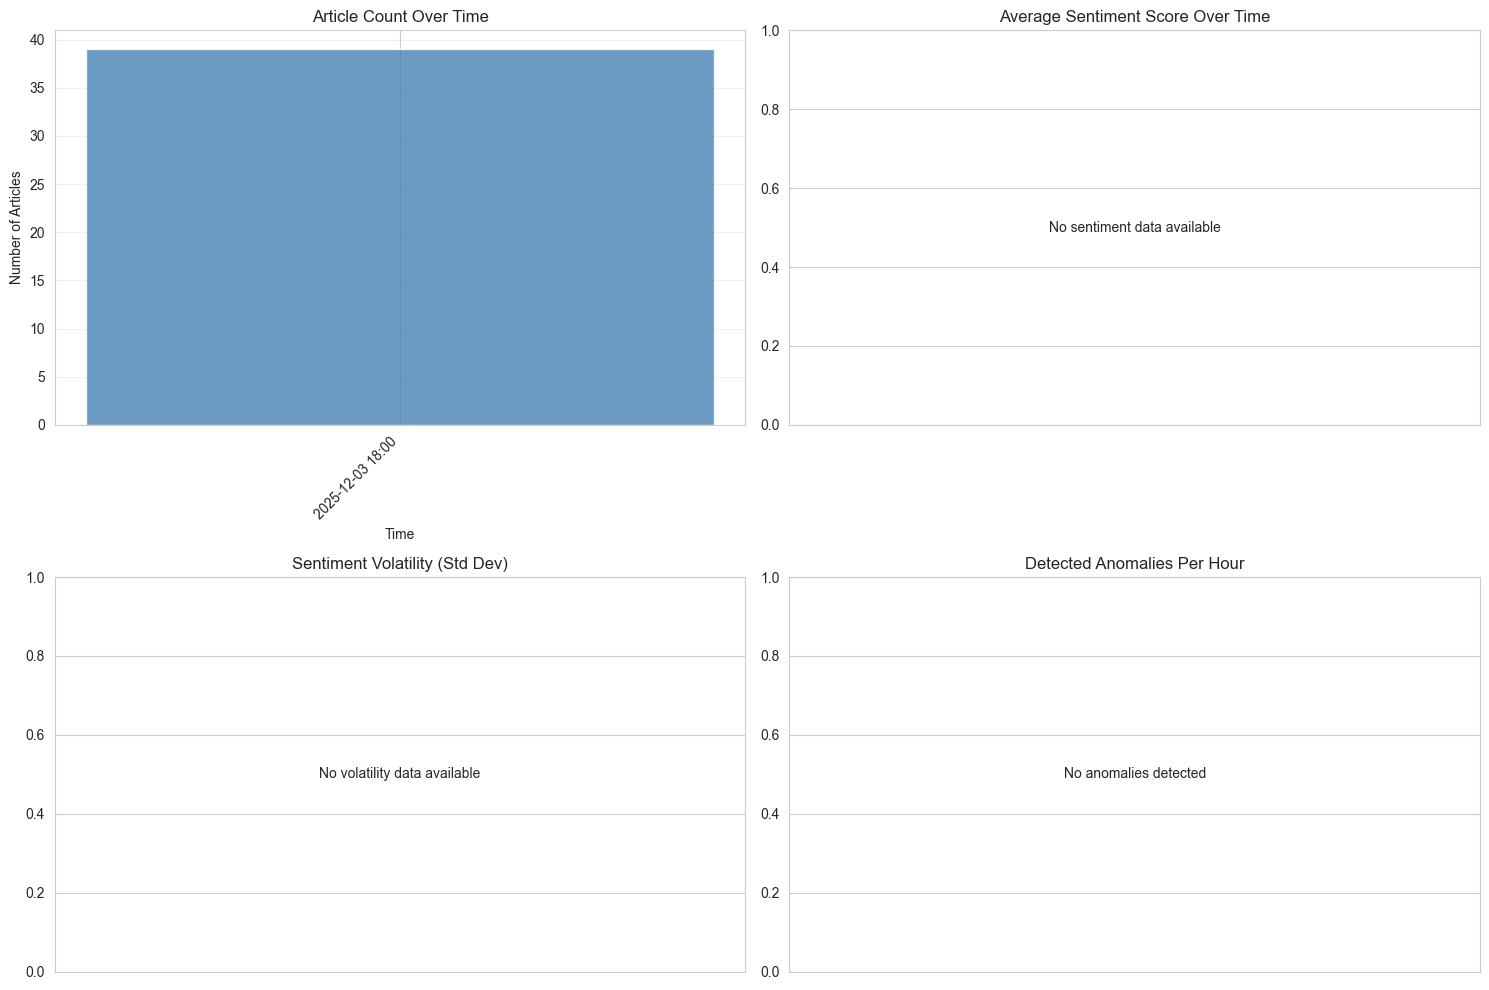


=== Summary Statistics ===
Total articles: 39
Average articles per hour: 39.00
Total anomalies detected: 0


In [14]:
# Create visualizations
if 'df_metrics' not in locals() or df_metrics.empty:
    print("No metrics to visualize. Please load data first.")
else:
    # Prepare axis positions and labels for clearer single/few-point charts
    x_pos = list(range(len(df_metrics)))
    if pd.api.types.is_datetime64_any_dtype(df_metrics['date']):
        x_labels = df_metrics['date'].dt.strftime('%Y-%m-%d %H:%M')
    else:
        x_labels = df_metrics['date'].astype(str)

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # 1. Article Count Over Time (bar to avoid weird date scaling)
    axes[0, 0].bar(x_pos, df_metrics['article_count'], color='steelblue', alpha=0.8)
    axes[0, 0].set_title("Article Count Over Time")
    axes[0, 0].set_xlabel("Time")
    axes[0, 0].set_ylabel("Number of Articles")
    axes[0, 0].set_xticks(x_pos)
    axes[0, 0].set_xticklabels(x_labels, rotation=45, ha='right')
    axes[0, 0].grid(True, alpha=0.3, axis='y')

    # 2. Sentiment Mean Over Time
    if df_metrics['sentiment_mean'].sum() != 0:
        axes[0, 1].plot(x_pos, df_metrics['sentiment_mean'], marker='s', linestyle='-', color='coral')
        axes[0, 1].set_title("Average Sentiment Score Over Time")
        axes[0, 1].set_xlabel("Time")
        axes[0, 1].set_ylabel("Sentiment Score")
        axes[0, 1].set_xticks(x_pos)
        axes[0, 1].set_xticklabels(x_labels, rotation=45, ha='right')
        axes[0, 1].grid(True, alpha=0.3)
    else:
        axes[0, 1].text(0.5, 0.5, 'No sentiment data available', ha='center', va='center')
        axes[0, 1].set_title("Average Sentiment Score Over Time")
        axes[0, 1].set_xticks([])

    # 3. Sentiment Volatility Over Time
    if df_metrics['sentiment_volatility'].sum() != 0:
        axes[1, 0].bar(x_pos, df_metrics['sentiment_volatility'], color='mediumseagreen', alpha=0.7)
        axes[1, 0].set_title("Sentiment Volatility (Std Dev)")
        axes[1, 0].set_xlabel("Time")
        axes[1, 0].set_ylabel("Volatility")
        axes[1, 0].set_xticks(x_pos)
        axes[1, 0].set_xticklabels(x_labels, rotation=45, ha='right')
        axes[1, 0].grid(True, alpha=0.3, axis='y')
    else:
        axes[1, 0].text(0.5, 0.5, 'No volatility data available', ha='center', va='center')
        axes[1, 0].set_title("Sentiment Volatility (Std Dev)")
        axes[1, 0].set_xticks([])

    # 4. Anomaly Count
    if df_metrics['anomaly_count'].sum() > 0:
        axes[1, 1].bar(x_pos, df_metrics['anomaly_count'], color='salmon', alpha=0.7)
        axes[1, 1].set_title("Detected Anomalies Per Hour")
        axes[1, 1].set_xlabel("Time")
        axes[1, 1].set_ylabel("Anomaly Count")
        axes[1, 1].set_xticks(x_pos)
        axes[1, 1].set_xticklabels(x_labels, rotation=45, ha='right')
        axes[1, 1].grid(True, alpha=0.3, axis='y')
    else:
        axes[1, 1].text(0.5, 0.5, 'No anomalies detected', ha='center', va='center')
        axes[1, 1].set_title("Detected Anomalies Per Hour")
        axes[1, 1].set_xticks([])

    plt.tight_layout()
    plt.show()

    # Summary Statistics
    print("\n=== Summary Statistics ===")
    print(f"Total articles: {df_metrics['article_count'].sum():.0f}")
    print(f"Average articles per hour: {df_metrics['article_count'].mean():.2f}")
    print(f"Total anomalies detected: {df_metrics['anomaly_count'].sum():.0f}")
    if df_metrics['sentiment_mean'].sum() != 0:
        print(f"Average sentiment: {df_metrics['sentiment_mean'].mean():.4f}")
        print(f"Max sentiment volatility: {df_metrics['sentiment_volatility'].max():.4f}")


### 4. Generate and save exploration report 

In [10]:
# Calculate and structure key findings for the presentation
report = {
    'total_days': len(df_metrics),
    'mean_sentiment': df_metrics['sentiment_mean'].mean(),
    'max_volatility_date': df_metrics.loc[df_metrics['sentiment_volatility'].idxmax(), 'date'].strftime('%Y-%m-%d'),
    # Add more key statistics here...
}

report_path = PROCESSED_DATA_DIR / 'exploration_summary.json'
with open(report_path, 'w') as f:
    json.dump(report, f, indent=4)
    
print(f"\n Exploration complete. Summary saved to: {report_path.relative_to(Path.cwd().parent)}")


 Exploration complete. Summary saved to: data\processed\exploration_summary.json
